# Online Payment Fraud Detection Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_auc_score as ras
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('Payment_logs.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:", len(object_cols))

int_ = (data.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:", len(num_cols))

fl = (data.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:", len(fl_cols))

Categorical variables: 3
Integer variables: 3
Float variables: 5


<Axes: xlabel='type', ylabel='count'>

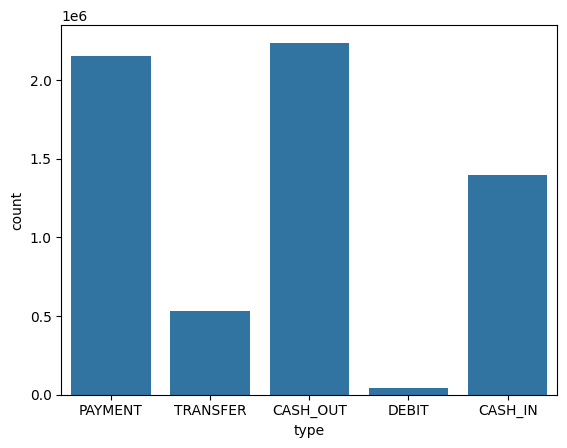

In [6]:
sns.countplot(x='type', data=data)

In [7]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

<Axes: xlabel='step', ylabel='Count'>

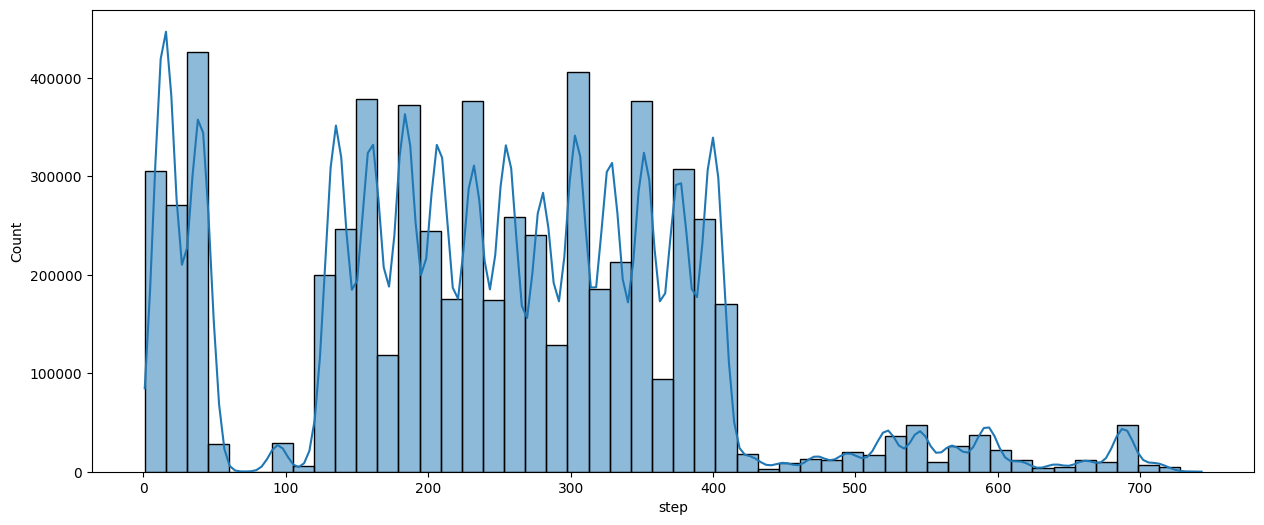

In [8]:
plt.figure(figsize=(15, 6))
sns.histplot(data['step'], bins=50, kde=True)

<Axes: >

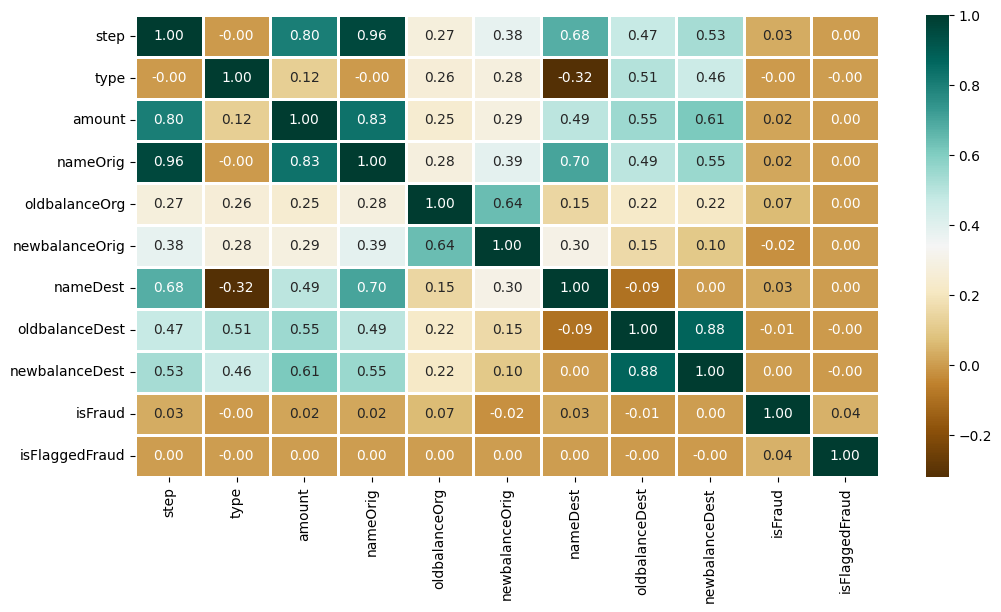

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.apply(lambda x: pd.factorize(x)[0]).corr(),
			cmap='BrBG',
			fmt='.2f',
			linewidths=2,
			annot=True)

In [10]:
type_new = pd.get_dummies(data['type'], drop_first=True)
data_new = pd.concat([data, type_new], axis=1)
data_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,False,False,True,False
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,False,False,True,False
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,False,False,False,True
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,True,False,False,False
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,False,False,True,False


In [13]:
X = data_new.drop(['isFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = data_new['isFraud']


X.shape, y.shape

((6362620, 11), (6362620,))

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=7)

model.fit(X_train, y_train)
print(f'{model} : ')
    
train_preds = model.predict_proba(X_train)[:, 1]
print('Training Accuracy : ', ras(y_train, train_preds))
    
y_preds = model.predict_proba(X_test)[:, 1]
print('Validation Accuracy : ', ras(y_test, y_preds))
print()

RandomForestClassifier(criterion='entropy', n_estimators=7, random_state=7) : 
Training Accuracy :  0.9999992846155892
Validation Accuracy :  0.9635718404867615



In [29]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_score = model.predict_proba(X_test)[:,1]
print(model)
print(classification_report(y_pred, y_test, labels=[0,1], target_names=['Non-Fraud [0]', 'Fraud [1]']), '\n')

RandomForestClassifier(criterion='entropy', n_estimators=7, random_state=7)
               precision    recall  f1-score   support

Non-Fraud [0]       1.00      1.00      1.00   1906753
    Fraud [1]       0.80      0.96      0.88      2033

     accuracy                           1.00   1908786
    macro avg       0.90      0.98      0.94   1908786
 weighted avg       1.00      1.00      1.00   1908786
 



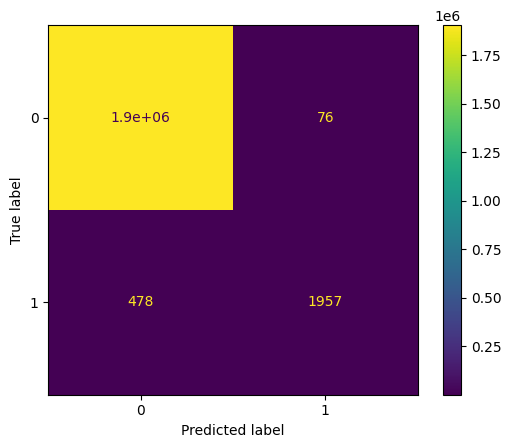

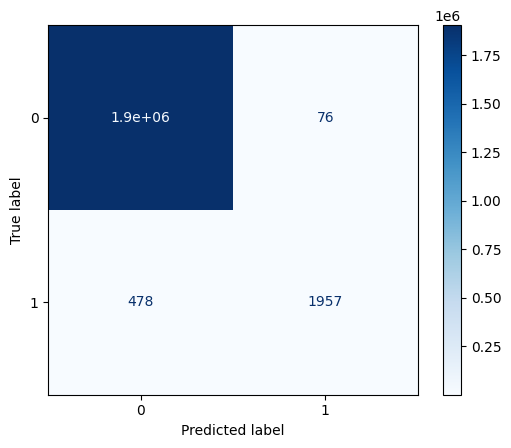

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test) 

cm.plot(cmap='Blues') 

plt.show()